In [ ]:
"""
This notebook finds the images that are highly memorized and analyzes if they share a common pattern.

1) find the units that memorized the most.
2) find the images that cost the most to memorize. 
"""

In [60]:
import torch
import os
import sys
PROJECT_ROOT = os.path.abspath("../..")
sys.path.insert(0, PROJECT_ROOT)

print("Project root:", PROJECT_ROOT)

import matplotlib.pyplot as plt
import numpy as np
from memorization.data_prep.subset_imagenet import get_balanced_imagenet_dataset

Project root: /BS/scene_repre/work/VAR


In [19]:
unit_mem_file = PROJECT_ROOT + "/memorization/unitmem_scores_corrected.pt"
# holds the unit_mem scores for the units.
# we are analyzing fc1_act. there are 16 blocks, and 10 scales. 
unit_mem_dict = torch.load(unit_mem_file)

In [20]:
all_scores = []
all_meta = []  # (key, block, scale, unit)

for key, blocks in unit_mem_dict.items():
    for block_idx, block in enumerate(blocks):
        # block: list of scales
        for scale_idx, unitmem_vec in enumerate(block):
            # unitmem_vec: (C,)
            C = unitmem_vec.numel()
            all_scores.append(unitmem_vec)  # tensor, NOT item()
            all_meta.extend(
                (key, block_idx, scale_idx, unit)
                for unit in range(C)
            )

# Concatenate once
scores = torch.cat(all_scores)  # shape: (num_units,)


In [21]:
threshold = torch.quantile(scores, 0.9)
print(f"UnitMem 90% threshold: {threshold.item():.4f}")

UnitMem 90% threshold: 0.6442


In [22]:
print(scores.shape)  # Should print (num_units,)
mask = scores >= threshold
top_indices = torch.where(mask)[0]

print(f"Number of top ~10% neurons: {top_indices.numel()}")


torch.Size([655360])
Number of top ~10% neurons: 65536


In [23]:
top_mem_neurons = [
    (scores[i].item(), *all_meta[i])
    for i in top_indices.tolist()
]

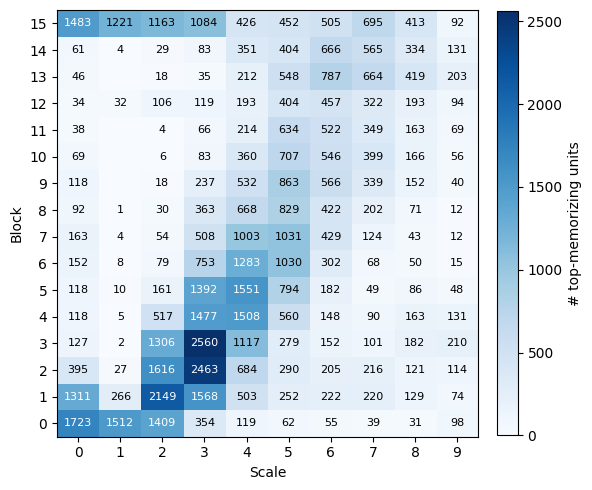

In [62]:
# Build a heatmap of top-memorizing units across (block, scale)

# Determine grid shape 
num_blocks = 16
num_scales = 10

counts = np.zeros((num_blocks, num_scales), dtype=int)

# Aggregate counts for top-memorizing units
for i in top_indices.tolist():
    # all_meta[i] = (key, block_idx, scale_idx, unit)
    _, block_idx, scale_idx, _ = all_meta[i]
    counts[block_idx, scale_idx] += 1

# Plot heatmap
plt.figure(figsize=(6, 5))
im = plt.imshow(counts, cmap="Blues", aspect="auto", origin="lower")
cb = plt.colorbar(im, fraction=0.046, pad=0.04)
cb.set_label("# top-memorizing units")
plt.xlabel("Scale")
plt.ylabel("Block")
plt.xticks(ticks=np.arange(num_scales))
plt.yticks(ticks=np.arange(num_blocks))
#plt.title("Distribution of top-10% memorizing units across (block, scale)")

# Optional: annotate non-zero cells
max_c = counts.max() if counts.size > 0 else 0
if max_c > 0:
    for b in range(num_blocks):
        for s in range(num_scales):
            c = counts[b, s]
            if c > 0:
                color = "white" if c > max_c / 2 else "black"
                plt.text(s, b, str(c), ha="center", va="center", color=color, fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
# sort based on unit mem score
top_mem_neurons.sort(reverse=True)

In [75]:
# save the block and scale of the top 20 highly memorizing units
top_20_memorized_units = []
for x in top_mem_neurons[:20]:
    top_20_memorized_units.append((x[2], x[3], x[4]))
    print(
        f"UnitMem={x[0]:.4f}, block={x[2]}, scale={x[3]}, unit={x[4]}"
    )

UnitMem=0.9995, block=1, scale=3, unit=1306
UnitMem=0.9991, block=1, scale=4, unit=1306
UnitMem=0.9990, block=1, scale=5, unit=1306
UnitMem=0.9986, block=14, scale=6, unit=1714
UnitMem=0.9984, block=1, scale=7, unit=1306
UnitMem=0.9981, block=0, scale=0, unit=3202
UnitMem=0.9980, block=1, scale=5, unit=3442
UnitMem=0.9977, block=14, scale=6, unit=488
UnitMem=0.9973, block=3, scale=2, unit=2489
UnitMem=0.9971, block=1, scale=8, unit=1306
UnitMem=0.9969, block=15, scale=3, unit=1953
UnitMem=0.9968, block=1, scale=4, unit=3442
UnitMem=0.9967, block=3, scale=6, unit=3122
UnitMem=0.9965, block=14, scale=4, unit=488
UnitMem=0.9964, block=5, scale=8, unit=3894
UnitMem=0.9962, block=1, scale=5, unit=2000
UnitMem=0.9960, block=14, scale=6, unit=4045
UnitMem=0.9958, block=14, scale=6, unit=2978
UnitMem=0.9957, block=14, scale=4, unit=4045
UnitMem=0.9957, block=15, scale=2, unit=2962


In [ ]:
"""
Now, coming to analyzing the images that are highly memorized.
"""

In [61]:
# load the dataset
dataset = get_balanced_imagenet_dataset(split="train", total_samples=12800)

In [49]:
path = "/scratch/inf0/user/hpetekka/var_mem/output_activations_corrected_test/combined/fc1_act"
blocks = []

for i in range(16):
    blocks.append(torch.load(os.path.join(path, f"block_{i}.pt")))  # shape: (N, C, H, W)

In [70]:
block_1 = blocks[1]  
print(block_1.keys())  # dict_keys(['activations', 'indices'])
print(block_1['activations'].shape)  # should be (num_images, num_scales, num_units)
print(block_1['indices'].shape)  # should be (num_images, num_scales, num_units)
print(max(block_1['indices']))

dict_keys(['activations', 'indices'])
torch.Size([12800, 10, 4096])
torch.Size([12800])
tensor(12799)


In [57]:
print(block_1['activations'][:, 3, 1306].shape)

# find the image that cause the max activation for unit 1306 at scale 3 in block 1
unit_activations = block_1['activations'][:, 3, 1306]  # shape: (num_images,)
max_activation, max_idx = torch.max(unit_activations, dim=0)
print(f"Max activation: {max_activation.item():.4f} at image index {max_idx.item()}")

mean_activation = torch.mean(unit_activations, dim=0)
print(f"Mean activation: {mean_activation.item():.8f}")

torch.Size([12800])
Max activation: 0.0020 at image index 10859
Mean activation: 0.00000066


In [69]:
print(len(dataset))  # (image, label)

12800


In [76]:
# prepare some indices to check the images
# top_20_memorized_units: block and scale
# find the image that causes the max activation for each of these units
memorized_indices = []
for block_idx, scale_idx, unit_idx in top_20_memorized_units:
    block = blocks[block_idx]
    unit_activations = block['activations'][:, scale_idx, unit_idx]  # shape: (num_images,)
    
    max_activation, max_idx = torch.max(unit_activations, dim=0)
    memorized_indices.append(max_idx.item())
        # print(
        #     f"Block={block_idx}, Scale={scale_idx}, Unit={unit_idx}, "
        #     f"MaxAct={max_activation.item():.4f} at ImgIdx={max_idx.item()}, "
        #     f"MeanAct={mean_activation.item():.8f}"
        # )

In [77]:
print("memorized_indices:", memorized_indices)

memorized_indices: [10859, 4966, 7211, 4863, 11409, 618, 4863, 1138, 1412, 11409, 4752, 8077, 4966, 11716, 8356, 4863, 6876, 1535, 5991, 11277]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4823529..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.84313726..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..1.0].
Clipping input data to the valid range for i

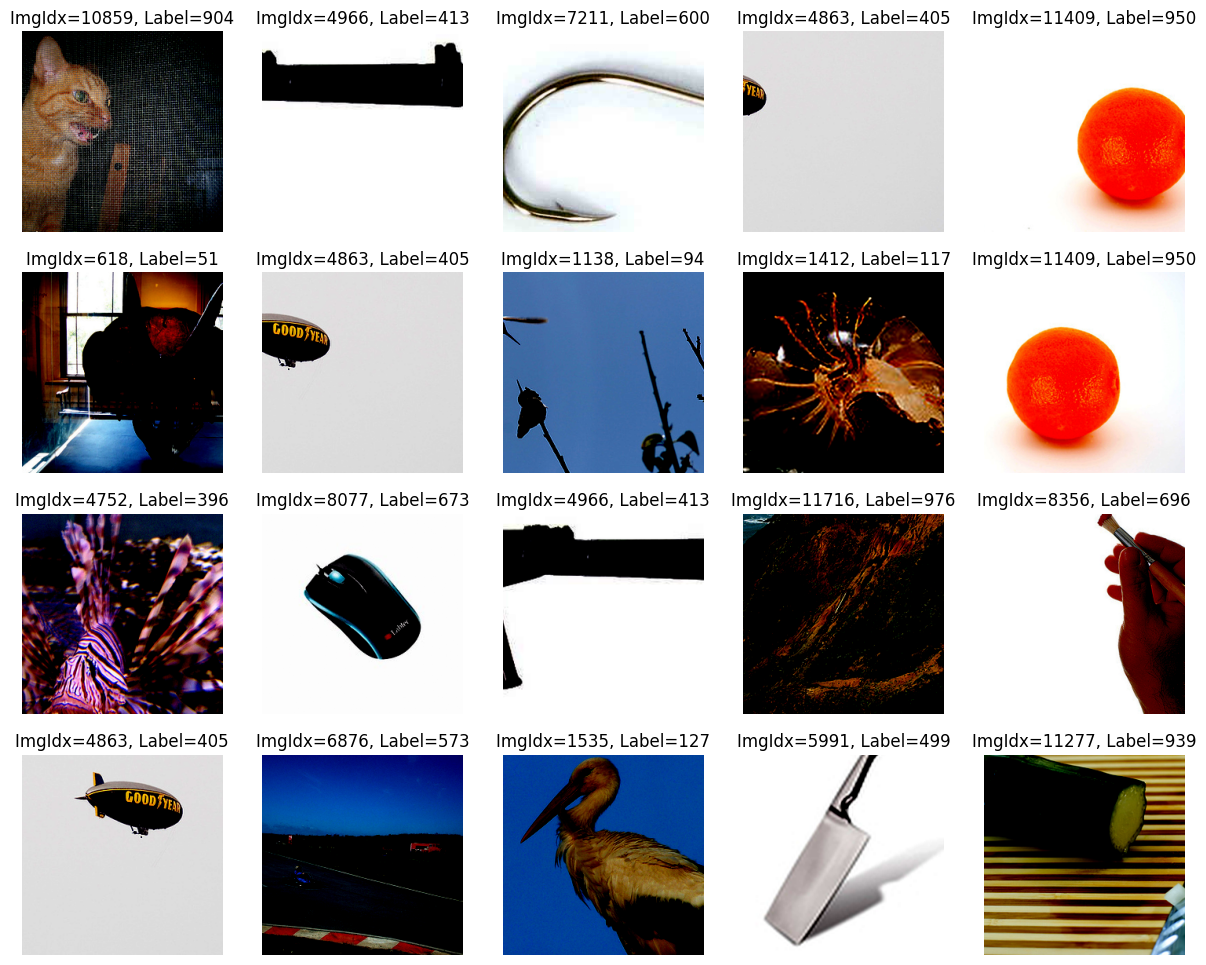

In [78]:
# show images in grid 5 by 4
num_images = len(memorized_indices)
num_cols = 5
num_rows = (num_images + num_cols - 1) // num_cols
plt.figure(figsize=(15, 3 * num_rows))
for i, img_idx in enumerate(memorized_indices):
    img, label = dataset[img_idx]
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(img.permute(1, 2, 0).numpy())
    plt.title(f"ImgIdx={img_idx}, Label={label}")
    plt.axis("off")